In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('/content/data-assignment2.csv')
index = pd.read_csv('/content/index-assignment2.csv')

In [ ]:
# Initialize an empty list to store combined data
combined_data = []

# Loop over each row in index_df
for _, row in index.iterrows():
    tweet_id = row['tweet_id']
    post_time_day = row['post_time_day']
    start_ind = int(row['start_ind'])  # Convert to integer
    end_ind = int(row['end_ind'])  # Convert to integer

    # Ensure start_ind is less than or equal to end_ind
    if start_ind <= end_ind:
        # Slice the corresponding data from data_df using start and end indices
        sliced_data = data.iloc[start_ind:end_ind+1].copy()  # +1 to include the end_ind row

        # Add tweet_id and post_time_day to the sliced data
        sliced_data['tweet_id'] = tweet_id
        sliced_data['post_time_day'] = post_time_day

        # Append the combined data to the list
        combined_data.append(sliced_data)

# Concatenate all the sliced data into a single dataframe
df = pd.concat(combined_data, ignore_index=True)

df.head()

,relative_time_second,number_of_followers,tweet_id,post_time_day
0,84833.0,46828,1.224346e+17,0.926644
1,84878.0,208,1.224346e+17,0.926644
2,84883.0,37,1.224346e+17,0.926644
3,84900.0,137,1.224346e+17,0.926644
4,84904.0,254,1.224346e+17,0.926644


In [ ]:
df.columns

Index(['relative_time_second', 'number_of_followers', 'tweet_id',
       'post_time_day'],
      dtype='object')

In [ ]:
df['cascade_size'] = df.groupby('tweet_id')['tweet_id'].transform('count')

#DeepCas

Preprocessing Steps

In [ ]:
features = ['relative_time_second', 'number_of_followers']
target = 'cascade_size'

In [ ]:
df.dropna(subset=features + [target], inplace=True)

In [ ]:
# Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features].values)

# Prepare target variable
y = df[target].values

In [ ]:
# Reshape Data for LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))  # LSTM input shape: (samples, timesteps, features)

In [ ]:
# Step 4: Define the DeepCas model
input_layer = Input(shape=(X.shape[1], X.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(32)(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Step 5: Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Fit the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 810s 6ms/step - loss: 2470673.7500 - val_loss: 6861073.5000
Epoch 2/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 816s 6ms/step - loss: 2302215.0000 - val_loss: 6861227.5000
Epoch 3/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 823s 6ms/step - loss: 2310099.5000 - val_loss: 6889217.5000
Epoch 4/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 861s 6ms/step - loss: 2305797.0000 - val_loss: 6864989.0000
Epoch 5/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 872s 6ms/step - loss: 2300209.0000 - val_loss: 6864613.5000
Epoch 6/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 833s 6ms/step - loss: 2301102.2500 - val_loss: 6850065.5000
Epoch 7/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 843s 6ms/step - loss: 2308990.0000 - val_loss: 6854150.5000
Epoch 8/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 837s 6ms/step - loss: 2297144.5000 - val_loss: 6858663.0000
Epoch 9/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━ 860s 6ms/step - loss: 2304346.0000 - val_loss: 6858646.0000
Epoch 10/10
143541/143541 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Step 6: Evaluate the model
# Use the last 20% of the training data for evaluation
y_pred = model.predict(X)

179426/179426 ━━━━━━━━━━━━━━━━━━━━ 314s 2ms/step


In [ ]:
# Calculate evaluation metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3209401.7144324332
Mean Absolute Error: 763.5046292189294


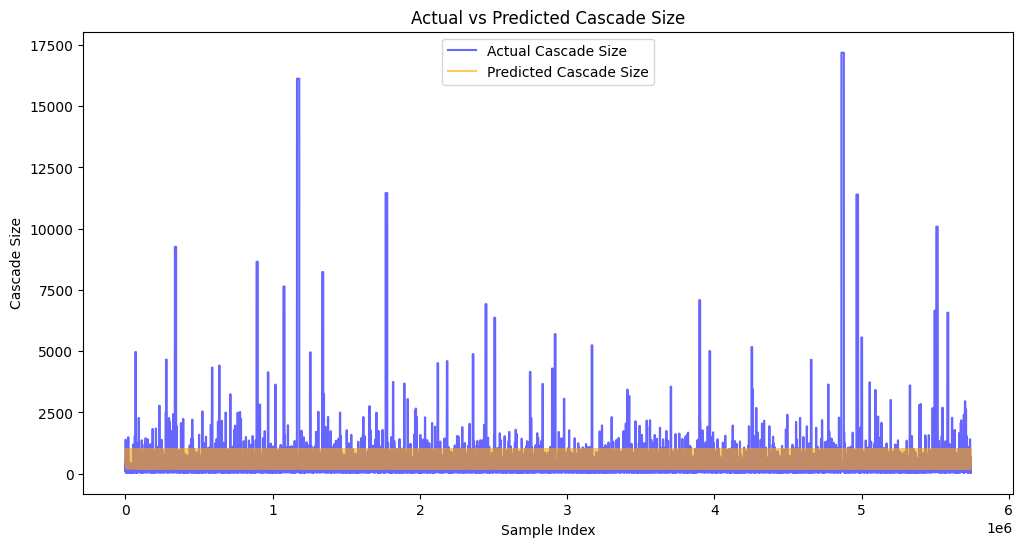

In [ ]:
import matplotlib.pyplot as plt
# Step 7: Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Cascade Size', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Cascade Size', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Cascade Size')
plt.xlabel('Sample Index')
plt.ylabel('Cascade Size')
plt.legend()
plt.show()